<a href="https://colab.research.google.com/github/jayeshgar/MyProjects/blob/main/RealNVP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
from tensorflow.keras import layers
from sklearn import datasets
import tensorflow_probability as tfp
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers

In [2]:
data = datasets.make_moons(3000,noise=0.05)[0].astype("float32")
norm = layers.Normalization()
norm.adapt(data)
normalized_data = norm(data)

In [3]:
#custom layer with keras api
output_dim = 256
reg = 0.01

def Coupling(input_shape):
  input = keras.layers.Input(shape=input_shape)

  t_layer_1 = keras.layers.Dense(output_dim, activation="relu", kernel_regularizer=regularizers.l2(reg))(input)
  t_layer_2 = keras.layers.Dense(output_dim, activation="relu", kernel_regularizer=regularizers.l2(reg))(t_layer_1)
  t_layer_3 = keras.layers.Dense(output_dim, activation="relu", kernel_regularizer=regularizers.l2(reg))(t_layer_2)
  t_layer_4 = keras.layers.Dense(output_dim, activation="relu", kernel_regularizer=regularizers.l2(reg))(t_layer_3)
  t_layer_5 = keras.layers.Dense(input_shape, activation="linear", kernel_regularizer=regularizers.l2(reg))(t_layer_4)

  s_layer_1 = keras.layers.Dense(output_dim, activation="relu", kernel_regularizer=regularizers.l2(reg))(input)
  s_layer_2 = keras.layers.Dense(output_dim, activation="relu", kernel_regularizer=regularizers.l2(reg))(s_layer_1)
  s_layer_3 = keras.layers.Dense(output_dim, activation="relu", kernel_regularizer=regularizers.l2(reg))(s_layer_2)
  s_layer_4 = keras.layers.Dense(output_dim, activation="relu", kernel_regularizer=regularizers.l2(reg))(s_layer_3)
  s_layer_5 = keras.layers.Dense(input_shape, activation="tanh", kernel_regularizer=regularizers.l2(reg))(s_layer_4)

  return keras.Model(inputs=input,outputs=[s_layer_5,t_layer_5])

In [23]:
class RealNVP(keras.Model):
  def __init__(self, num_coupling_layers):
    super().__init__()
    self.num_coupling_layers = num_coupling_layers

    #Distribution of the latent space
    self.distribution = tfp.distributions.MultivariateNormalDiag(loc=[0.0,0.0], scale_diag=[1.0,1.0])
    self.masks = np.array([[0,1],[1,0]] * (num_coupling_layers//2), dtype="float32")
    print("self.masks = ", self.masks)
    self.loss_tracker = keras.metrics.Mean(name="loss")
    self.layers_list = [Coupling(2) for i in range(num_coupling_layers)]

  @property
  def metrics(self):
    return [self.loss_tracker]

  def call(self,x,training=True):
    log_det_inv = 0
    direction = 1
    if training:
      direction = -1
    for i in range(self.num_coupling_layers)[::direction]:
      x_masked = x*self.masks[i]
      print("x_masked = ",x_masked)
      reversed_mask = 1 - self.masks[i]
      print("reversed_mask = ",reversed_mask)
      s,t = self.layers_list[i](x_masked)
      s *= reversed_mask
      t *= reversed_mask
      gate = (direction - 1)/2
      x = (
          reversed_mask
           *(x*tf.exp(direction*s) + direction*t*tf.exp(gate*s))
           + x_masked
      )
      log_det_inv += gate * tf.reduce_sum(s, [1])
    return x, log_det_inv

   #log likelihood of the normal distribution plus the log determinant of the jacobian
  def log_loss(self, x):
      y, logdet = self(x)
      log_likelihood = self.distribution.log_prob(y) + logdet
      return -tf.reduce_mean(log_likelihood)

  def train_step(self, data):
    with tf.GradientTape() as tape:
      loss = self.log_loss(data)
    g = tape.gradient(loss, self.trainable_variables)
    self.optimizer.apply_gradients(zip(g, self.trainable_variables))
    self.loss_tracker.update_state(loss)

    return {"loss": self.loss_tracker.result()}

  def test_step(self, data):
    loss = self.log_loss(data)
    self.loss_tracker.update_state(loss)

    return {"loss": self.loss_tracker.result()}

In [24]:
model = RealNVP(num_coupling_layers = 6)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001))
history = model.fit(
    normalized_data, batch_size=256, epochs=1, verbose=2, validation_split=0.2
)

self.masks =  [[0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]]
x_masked =  Tensor("real_nvp_5/mul:0", shape=(None, 2), dtype=float32)
reversed_mask =  [0. 1.]
x_masked =  Tensor("real_nvp_5/mul_10:0", shape=(None, 2), dtype=float32)
reversed_mask =  [1. 0.]
x_masked =  Tensor("real_nvp_5/mul_20:0", shape=(None, 2), dtype=float32)
reversed_mask =  [0. 1.]
x_masked =  Tensor("real_nvp_5/mul_30:0", shape=(None, 2), dtype=float32)
reversed_mask =  [1. 0.]
x_masked =  Tensor("real_nvp_5/mul_40:0", shape=(None, 2), dtype=float32)
reversed_mask =  [0. 1.]
x_masked =  Tensor("real_nvp_5/mul_50:0", shape=(None, 2), dtype=float32)
reversed_mask =  [1. 0.]
x_masked =  Tensor("real_nvp_5/mul:0", shape=(None, 2), dtype=float32)
reversed_mask =  [0. 1.]
x_masked =  Tensor("real_nvp_5/mul_10:0", shape=(None, 2), dtype=float32)
reversed_mask =  [1. 0.]
x_masked =  Tensor("real_nvp_5/mul_20:0", shape=(None, 2), dtype=float32)
reversed_mask =  [0. 1.]
x_masked =  Tensor("real_nvp_5/mul_30:0", shap

94/94 [==============================] - 1s 4ms/step


(-2.0, 2.0)

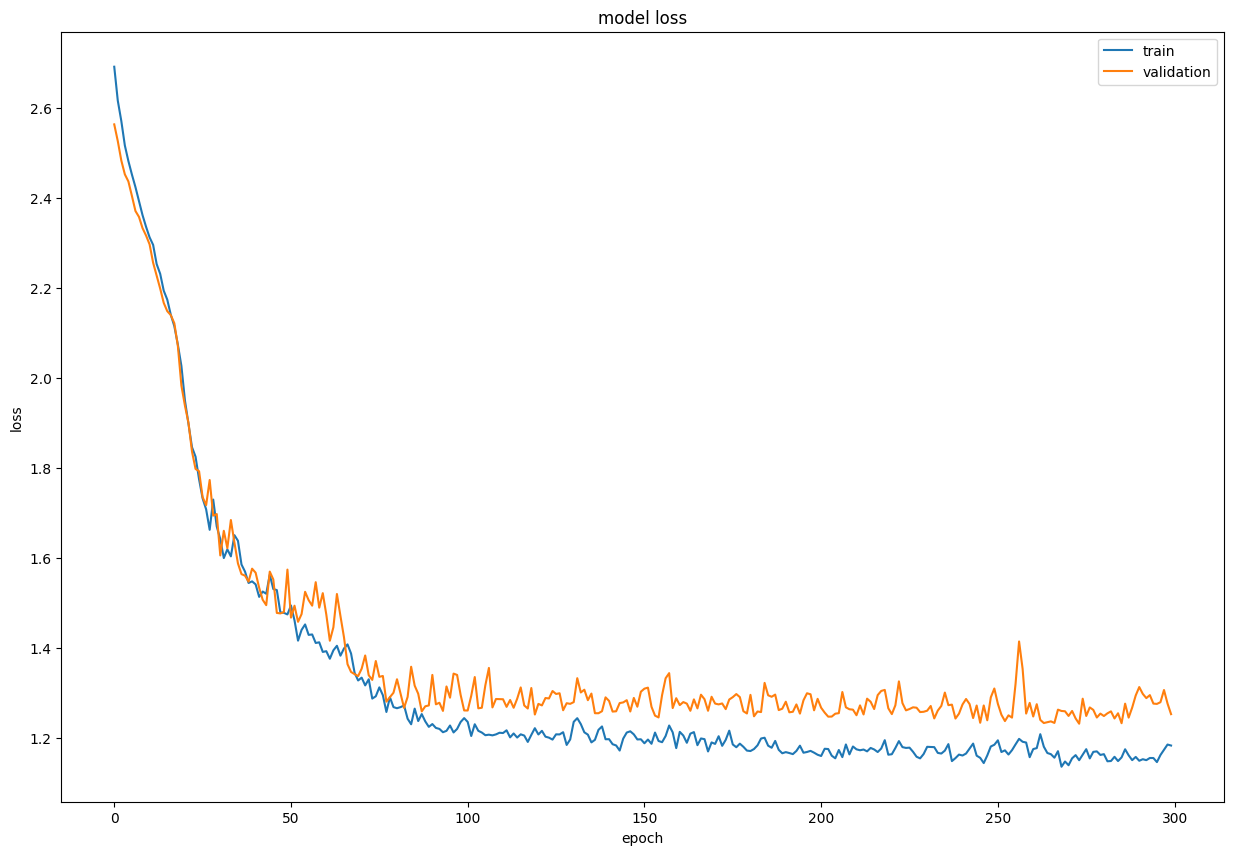

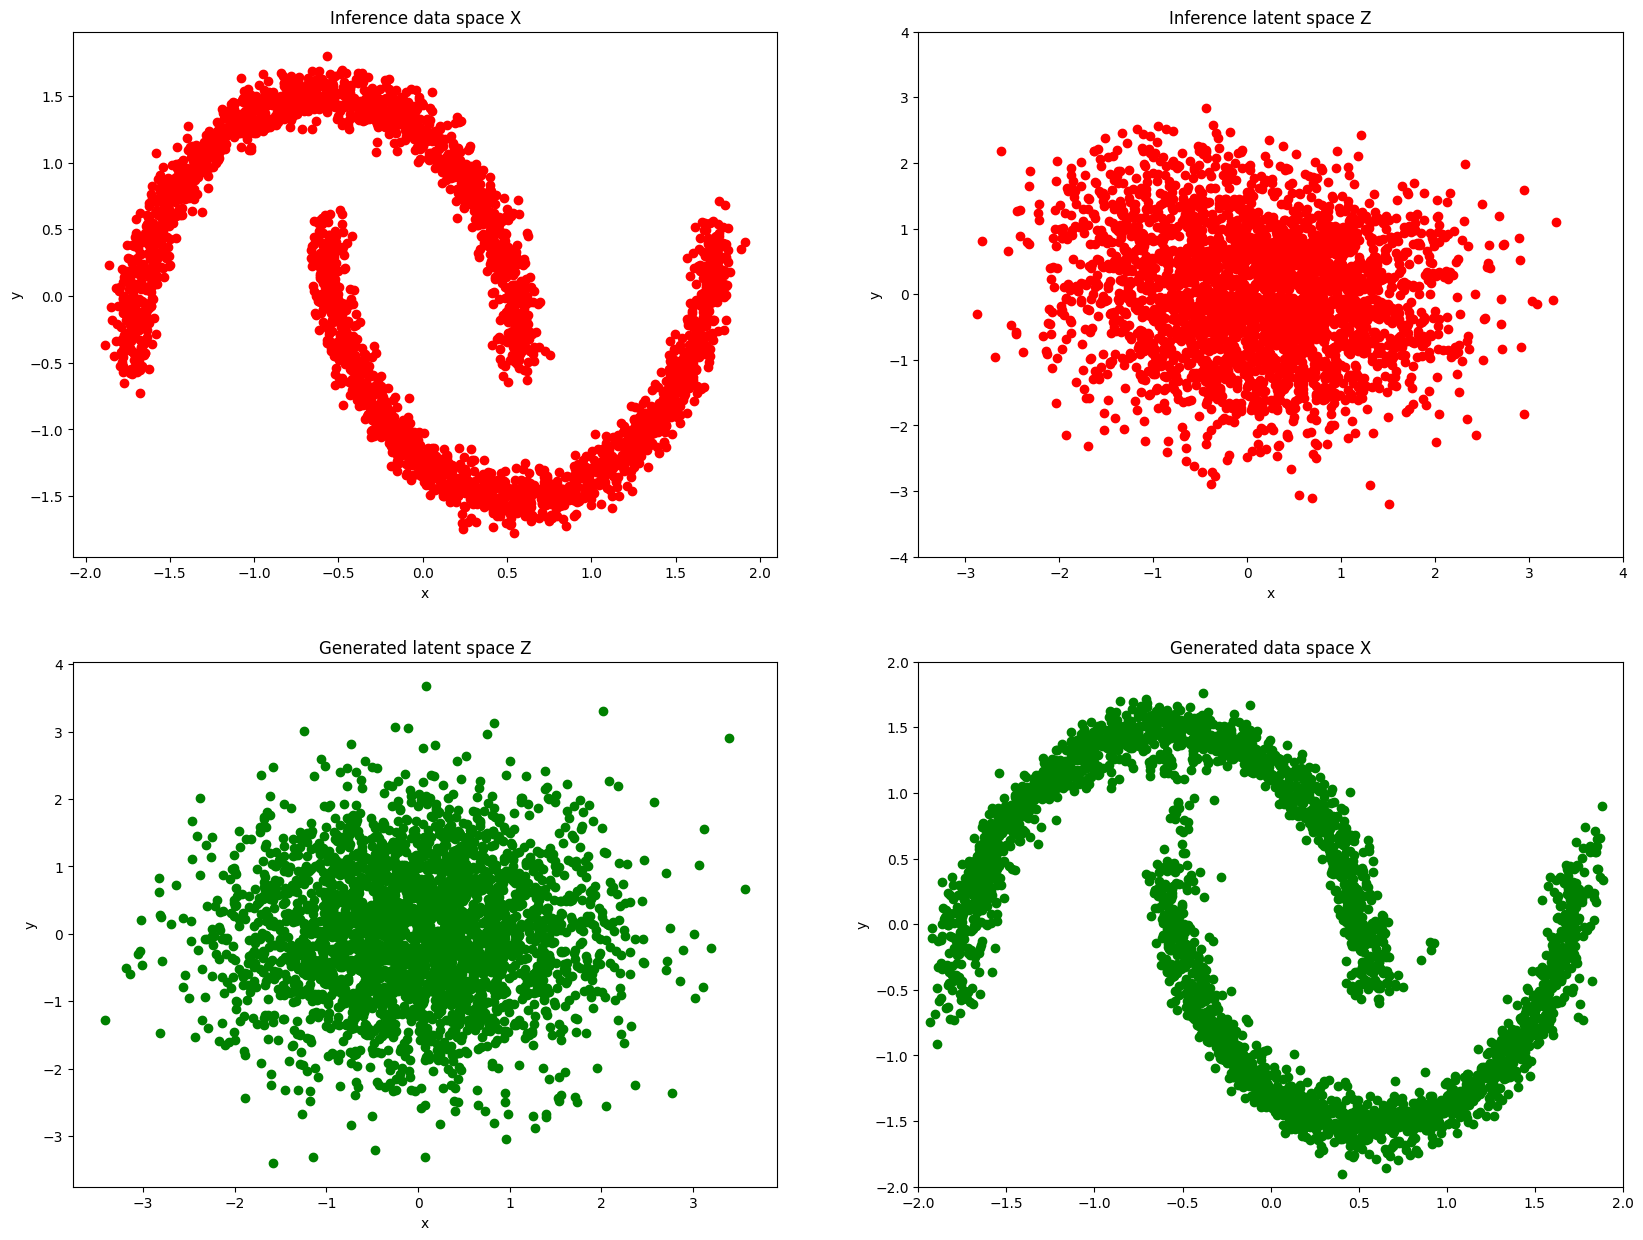

In [20]:
plt.figure(figsize=(15, 10))
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.legend(["train", "validation"], loc="upper right")
plt.ylabel("loss")
plt.xlabel("epoch")

# From data to latent space.
z, _ = model(normalized_data)

# From latent space to data.
samples = model.distribution.sample(3000)
x, _ = model.predict(samples)

f, axes = plt.subplots(2, 2)
f.set_size_inches(20, 15)

axes[0, 0].scatter(normalized_data[:, 0], normalized_data[:, 1], color="r")
axes[0, 0].set(title="Inference data space X", xlabel="x", ylabel="y")
axes[0, 1].scatter(z[:, 0], z[:, 1], color="r")
axes[0, 1].set(title="Inference latent space Z", xlabel="x", ylabel="y")
axes[0, 1].set_xlim([-3.5, 4])
axes[0, 1].set_ylim([-4, 4])
axes[1, 0].scatter(samples[:, 0], samples[:, 1], color="g")
axes[1, 0].set(title="Generated latent space Z", xlabel="x", ylabel="y")
axes[1, 1].scatter(x[:, 0], x[:, 1], color="g")
axes[1, 1].set(title="Generated data space X", label="x", ylabel="y")
axes[1, 1].set_xlim([-2, 2])
axes[1, 1].set_ylim([-2, 2])